In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import median_filter
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

In [2]:
hdul = fits.open('/content/hlsp_heritage_hst_acs-wfc_m51_f555w_v1_drz_sci.fits')
image_data = hdul[0].data
hdul.close()


In [3]:
image_data = image_data / np.max(image_data)

In [4]:
def crop_center(img, cropx=512, cropy=512):
    y, x = img.shape
    startx = x // 2 - cropx // 2
    starty = y // 2 - cropy // 2
    return img[starty:starty+cropy, startx:startx+cropx]


In [5]:
image_data = crop_center(image_data)

noise_sigma = 0.1
noisy_image = image_data + np.random.normal(0, noise_sigma, image_data.shape)

In [6]:
def stretch_contrast(image, lower_percentile=1, upper_percentile=99):
    p_low, p_high = np.percentile(image, (lower_percentile, upper_percentile))
    stretched = np.clip(image, p_low, p_high)
    return (stretched - p_low) / (p_high - p_low + 1e-8)

In [7]:
from skimage.restoration import denoise_wavelet

In [13]:
wavelet_denoised = denoise_wavelet(
    noisy_image,
    method='BayesShrink',
    mode='soft',
    wavelet_levels=3,
    wavelet='db1',
    rescale_sigma=True
)

In [14]:
wavelet_vis = stretch_contrast(wavelet_denoised)


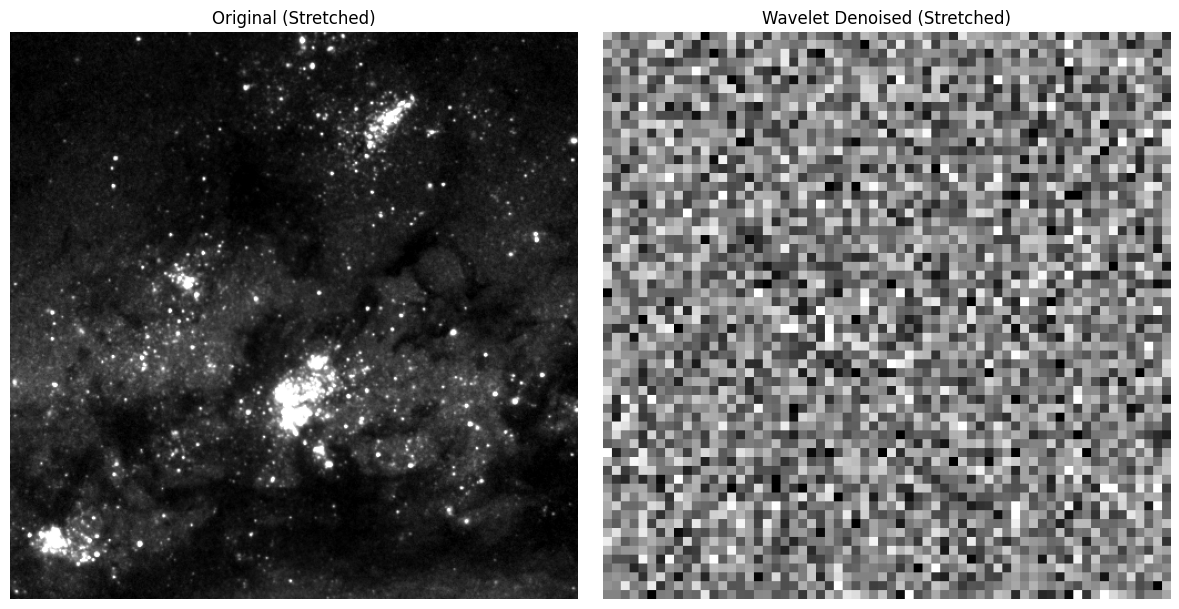

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
titles = ['Original (Stretched)', 'Wavelet Denoised (Stretched)']
images = [stretch_contrast(image_data), wavelet_vis]

for ax, img, title in zip(axes, images, titles):
    ax.imshow(img, cmap='gray', origin='lower')
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [16]:
psnr_wavelet = peak_signal_noise_ratio(image_data, wavelet_denoised, data_range=1.0)
ssim_wavelet = structural_similarity(image_data, wavelet_denoised, data_range=1.0)

print("Wavelet Filter → PSNR:", psnr_wavelet)
print("Wavelet Filter → SSIM:", ssim_wavelet)

Wavelet Filter → PSNR: 38.14767146970567
Wavelet Filter → SSIM: 0.6505441476967541
